In [1]:
## Importing libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()

In [2]:
match_lvl_data = pd.read_csv('/Users/alokroy/Documents/Programming/Projects/Amex/data/main/664389efa0868_match_level_scorecard.csv')
batsman_lvl_data = pd.read_csv('/Users/alokroy/Documents/Programming/Projects/Amex/data/main/663e2b548c98c_batsman_level_scorecard.csv')
bowler_lvl_data = pd.read_csv('/Users/alokroy/Documents/Programming/Projects/Amex/data/main/663e2b2c60743_bowler_level_scorecard.csv')
train_data = pd.read_csv('/Users/alokroy/Documents/Programming/Projects/Amex/data/main/663e2b6d54457_train_data_with_samplefeatures.csv')
test_data = pd.read_csv('/Users/alokroy/Documents/Programming/Projects/Amex/data/main/6644a1e287df6_test_data_with_samplefeatures.csv')

In [3]:
## Creating a binary winner column - 0 if team1 wins, else 1
train_data['winner_01'] = train_data.apply(lambda x: 0 if (x['team1']==x['winner']) else 1, axis=1)

In [4]:
def giveLastNgamesPlayer(player_id, date, n, bat_or_bowl):
    '''
    Function to get last n games stats of a player before an input date.

    Input-
    1. player_id: id of the player to get historical data.
    2. date: date to look-back and get n games. Stats returned are before this input date.
    3. n: Number of historical games stats to return.
    4. bat_or_bowl: Kind of stats to return. {'bat': batting stats to return, 'bowl': bowling stats to return}

    Output-None

    Returns- dataframe having bowling/batting stats from last n games of a player before an input date.
    The results are sorted by date.
    '''
    if bat_or_bowl == 'bat':
        df_topick = batsman_lvl_data
        id_col = 'batsman_id'
    else:
        df_topick = bowler_lvl_data
        id_col = 'bowler_id'

    return df_topick[(df_topick['match_dt']<date)&(df_topick[id_col]==float(player_id))]\
                .sort_values(by='match_dt', ascending=False).head(n)

In [5]:
def calculate_ratio(row, col1, col2):
    value1 = row[col1]
    value2 = row[col2]
    if value2 == 0:
        return value1
    else:
        return value1 / value2

# Function to add a ratio column for any two columns
def add_ratio_column(df, col1, col2, new_col_name):
    df[new_col_name] = df.apply(lambda row: calculate_ratio(row, col1, col2), axis=1)
    return df

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pandas as pd

def check_distribution_match(train_feature, test_feature):
    """
    Checks and visualizes if the distributions of a feature in the train and test datasets match.

    Args:
    train_feature (pd.Series): Feature data from the training dataset.
    test_feature (pd.Series): Feature data from the testing dataset.
    """

    # Visualizing distributions with histograms
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(train_feature, bins=30, alpha=0.5, color='blue', label='Train', density=True)
    plt.hist(test_feature, bins=30, alpha=0.5, color='red', label='Test', density=True)
    plt.legend(loc='upper right')
    plt.title('Histogram Comparison')

    # Density plot comparison
    plt.subplot(1, 2, 2)
    sns.kdeplot(train_feature, label='Train', fill=True, color='blue')
    sns.kdeplot(test_feature, label='Test', fill=True, color='red')
    plt.legend()
    plt.title('Density Plot Comparison')
    plt.tight_layout()
    plt.show()

    # Statistical test - Kolmogorov-Smirnov Test
    ks_stat, ks_pvalue = stats.ks_2samp(train_feature, test_feature)
    print(f"Kolmogorov-Smirnov test result: KS statistic = {ks_stat:.4f}, p-value = {ks_pvalue:.4f}")

    # Additional insights from descriptive statistics
    compare_stats = pd.DataFrame({
        'Train Stats': train_feature.describe(),
        'Test Stats': test_feature.describe()
    })
    print("\nDescriptive Statistics Comparison:")
    print(compare_stats)

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re

# Set seaborn style
sns.set(style="whitegrid")

def createRnP(X_12, feature, N=5, ylim_lb=0.3, ylim_ub=0.7):
    '''
    Rank and Plot of input feature on the input data. The y-axis shows %team1 wins in each bucket.
    
    Parameters-
    1. X_12: dataset to build the RnP on. 
    2. feature: Feature to build RnP of.
    3. N: number of bins on x-axis. Default 5.
    4. ylim_lb: lower bound of y axis on plot.
    5. ylim_ub: upper bound of y axis on plot.
    
    Output-
    1. Rank and Plot
    
    Returns- None
    '''
    df = X_12.copy()
    df[f'{feature}_bin'] = df[feature].rank(pct=True)//(1/N) # divide feature values for all games in 5 equi-volume buckets.
    df['count'] = 1
    df['team1_win%'] = df['winner_01'].apply(lambda x: 1-x) # invert winner_01 to get team1 winner indicator
    df['team2_win%'] = df['winner_01'].copy()
    df[f'{feature}_min'] = df[feature].copy()
    df[f'{feature}_max'] = df[feature].copy()
    df_g = df.groupby(f'{feature}_bin').agg({'team1_win%':'mean', 'team2_win%':'mean', 'count':'sum', f'{feature}_min':'min',\
                                            f'{feature}_max':'max'}).reset_index()
    N = min(N,df_g.shape[0])
    blue_bar = df_g['team1_win%'].values.tolist()
    ind = np.arange(N)
    # plotting starts
    plt.figure(figsize=(10,5));
    plt.bar(ind, blue_bar, label='Team 1 win%');
    plt.axhline(y=0.5, linewidth=0.5, color='k', linestyle = '--')
    xlabel = re.sub('team_','ratio_',feature)
    plt.xlabel(f'{xlabel} (team1 / team2) bins');
    plt.ylabel('Win %');
    plt.title(f'RnP - {feature} vs win');
    df_g['xticks'] = df_g.apply(lambda x: str(round(x[f'{feature}_min'],2)) + ' - ' + str(round(x[f'{feature}_max'],2)), axis=1)
    plt.xticks(ind, df_g['xticks']);
    plt.ylim([ylim_lb,ylim_ub]);
    plt.legend(loc='best');
    x2,x1 = blue_bar[-1],blue_bar[0]
    slope = x2/x1
    if slope < 1:
        slope = 1/slope
        x1,x2 = x2,x1
    print('slope:', round(x2,2),'/',round(x1,2), '= ',round(slope,2))
    plt.show();
    
    correlation = df['winner_01'].corr(df[feature])
    print(f"Correlation between {feature} and winner_01 is: {correlation}") 

## Features

In [10]:
num_matches = 5

In [11]:
def average_runs(match_lvl_data, team_id, date, recent_n):
    # Filter matches involving the specified team before the given date and take the last 'n' matches
    recent_matches = match_lvl_data[((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id)) &
                                    (match_lvl_data['match_dt'] < date)].tail(recent_n)
    
    # Calculate runs scored by the team in these matches
    runs_scored = recent_matches.apply(lambda row: row['inning1_runs'] if row['team1_id'] == team_id else row['inning2_runs'], axis=1)
    
    # Return the average runs
    return runs_scored.mean() if not runs_scored.empty else 0

In [15]:
train_data['team1_average_runs'] = train_data.apply(lambda x: average_runs(match_lvl_data, x['team1_id'], x['match_dt'],recent_n=num_matches), axis=1)
train_data['team2_average_runs'] = train_data.apply(lambda x: average_runs(match_lvl_data, x['team2_id'], x['match_dt'],recent_n=num_matches), axis=1)

train_data = add_ratio_column(train_data, 'team1_average_runs', 'team2_average_runs', 'team_average_runs_ratio')

train_data.drop(['team1_average_runs', 'team2_average_runs'], axis=1, inplace=True)

test_data['team1_average_runs'] = test_data.apply(lambda x: average_runs(match_lvl_data, x['team1_id'], x['match_dt'],recent_n=num_matches), axis=1)
test_data['team2_average_runs'] = test_data.apply(lambda x: average_runs(match_lvl_data, x['team2_id'], x['match_dt'],recent_n=num_matches), axis=1)

test_data = add_ratio_column(test_data, 'team1_average_runs', 'team2_average_runs', 'team_average_runs_ratio')

test_data.drop(['team1_average_runs', 'team2_average_runs'], axis=1, inplace=True)

slope: 0.53 / 0.4 =  1.35


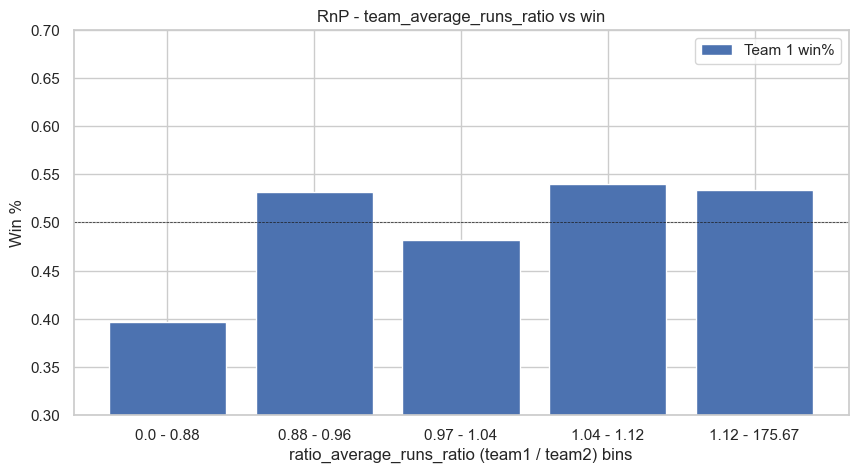

Correlation between team_average_runs_ratio and winner_01 is: -0.03967559480425621


In [17]:
createRnP(train_data, 'team_average_runs_ratio')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


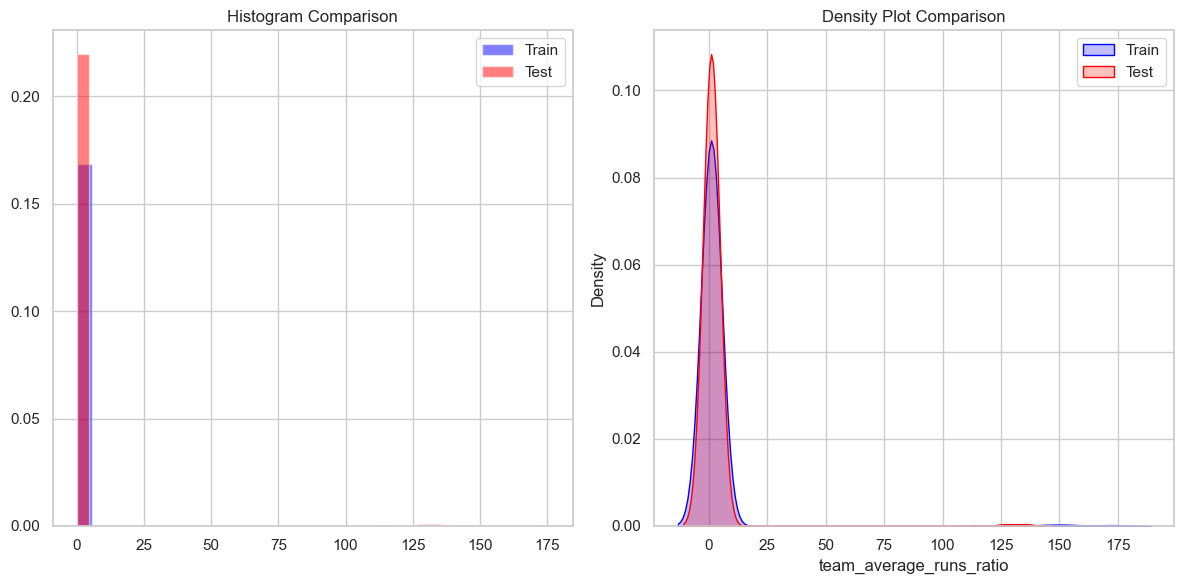

Kolmogorov-Smirnov test result: KS statistic = 0.0747, p-value = 0.1779

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      3.104523    1.956888
std      17.463462   11.181764
min       0.000000    0.000000
25%       0.901290    0.903001
50%       1.002778    1.007194
75%       1.100517    1.123293
max     175.666667  135.600000


In [18]:
check_distribution_match(train_data['team_average_runs_ratio'], test_data['team_average_runs_ratio'])

2.

In [22]:
def performance_by_venue(match_lvl_data, team_id, venue, date, recent_n=5):
    # Filter matches for the specified team and venue before the given date
    recent_matches = match_lvl_data[((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id)) &
                                    (match_lvl_data['venue'] == venue) &
                                    (match_lvl_data['match_dt'] < date)].tail(recent_n)
    
    # Calculate win rate
    wins = recent_matches['winner_id'].apply(lambda x: 1 if x == team_id else 0).sum()
    
    # Return win rate
    return wins / recent_n if recent_matches.shape[0] > 0 else 0

In [23]:
train_data['team1_venue_win_rate'] = train_data.apply(lambda x: performance_by_venue(match_lvl_data, x['team1_id'], x['venue'], x['match_dt'], recent_n=num_matches), axis=1)
train_data['team2_venue_win_rate'] = train_data.apply(lambda x: performance_by_venue(match_lvl_data, x['team2_id'], x['venue'], x['match_dt'], recent_n=num_matches), axis=1)

train_data = add_ratio_column(train_data, 'team1_venue_win_rate', 'team2_venue_win_rate', 'team_venue_win_rate_ratio')

train_data.drop(['team1_venue_win_rate', 'team2_venue_win_rate'], axis=1, inplace=True)

test_data['team1_venue_win_rate'] = test_data.apply(lambda x: performance_by_venue(match_lvl_data, x['team1_id'], x['venue'], x['match_dt'], recent_n=num_matches), axis=1)
test_data['team2_venue_win_rate'] = test_data.apply(lambda x: performance_by_venue(match_lvl_data, x['team2_id'], x['venue'], x['match_dt'], recent_n=num_matches), axis=1)

test_data = add_ratio_column(test_data, 'team1_venue_win_rate', 'team2_venue_win_rate', 'team_venue_win_rate_ratio')

test_data.drop(['team1_venue_win_rate', 'team2_venue_win_rate'], axis=1, inplace=True)

slope: 0.52 / 0.47 =  1.11


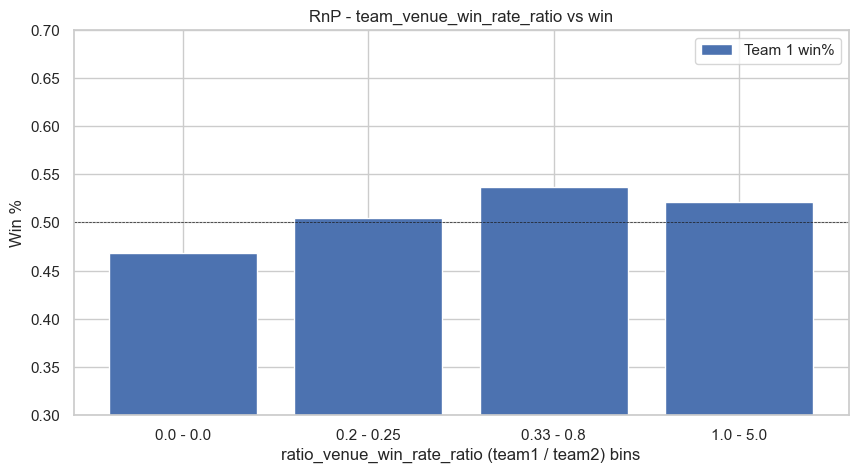

Correlation between team_venue_win_rate_ratio and winner_01 is: -0.046377382165254694


In [24]:
createRnP(train_data, 'team_venue_win_rate_ratio')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


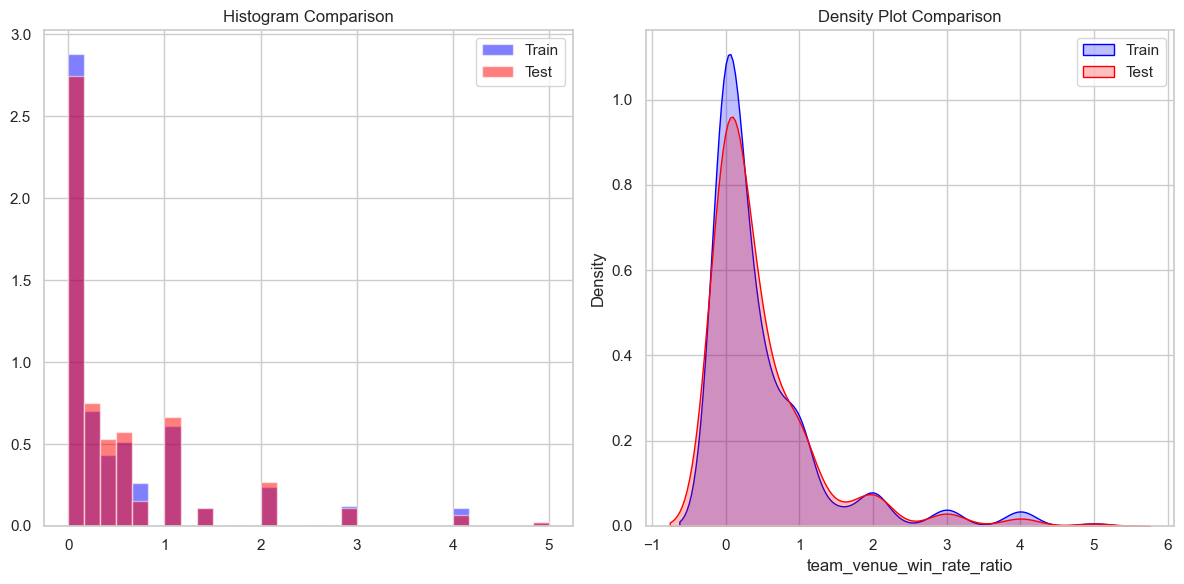

Kolmogorov-Smirnov test result: KS statistic = 0.0224, p-value = 0.9998

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      0.490436    0.476384
std       0.826306    0.776120
min       0.000000    0.000000
25%       0.000000    0.000000
50%       0.200000    0.200000
75%       0.600000    0.600000
max       5.000000    5.000000


In [25]:
check_distribution_match(train_data['team_venue_win_rate_ratio'], test_data['team_venue_win_rate_ratio'])

3.

In [37]:
def performance_in_series_type(match_lvl_data, team_id, series_type, date, recent_n=5):
    recent_matches = match_lvl_data[((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id)) &
                                    (match_lvl_data['series_name'] == series_type) &
                                    (match_lvl_data['match_dt'] < date)].tail(recent_n)
    wins = recent_matches['winner_id'].apply(lambda x: 1 if x == team_id else 0).sum()
    return (wins / recent_n) if recent_n > 0 else 0

In [38]:
train_data['team1_series_type_win_rate'] = train_data.apply(lambda x: performance_in_series_type(match_lvl_data, x['team1_id'], x['series_name'], x['match_dt'], recent_n=num_matches), axis=1)
train_data['team2_series_type_win_rate'] = train_data.apply(lambda x: performance_in_series_type(match_lvl_data, x['team2_id'], x['series_name'], x['match_dt'], recent_n=num_matches), axis=1)

train_data = add_ratio_column(train_data, 'team1_series_type_win_rate', 'team2_series_type_win_rate', 'team_series_type_win_rate_ratio')

train_data.drop(['team1_series_type_win_rate', 'team2_series_type_win_rate'], axis=1, inplace=True)

test_data['team1_series_type_win_rate'] = test_data.apply(lambda x: performance_in_series_type(match_lvl_data, x['team1_id'], x['series_name'], x['match_dt'], recent_n=num_matches), axis=1)

test_data['team2_series_type_win_rate'] = test_data.apply(lambda x: performance_in_series_type(match_lvl_data, x['team2_id'], x['series_name'], x['match_dt'], recent_n=num_matches), axis=1)

test_data = add_ratio_column(test_data, 'team1_series_type_win_rate', 'team2_series_type_win_rate', 'team_series_type_win_rate_ratio')

test_data.drop(['team1_series_type_win_rate', 'team2_series_type_win_rate'], axis=1, inplace=True)

slope: 0.55 / 0.47 =  1.16


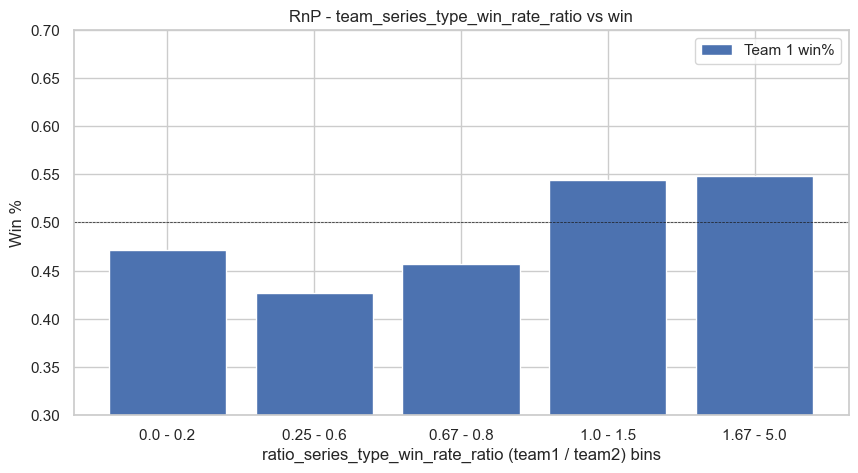

Correlation between team_series_type_win_rate_ratio and winner_01 is: -0.07427144948582265


In [39]:
createRnP(train_data, 'team_series_type_win_rate_ratio')

4.

In [42]:
def venue_success_rate(match_lvl_data, team_id, venue_name, date, recent_n=5):
    matches_at_venue = match_lvl_data[((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id)) &
                                      (match_lvl_data['venue'] == venue_name) &
                                      (match_lvl_data['match_dt'] < date)].tail(recent_n)
    wins = matches_at_venue['winner_id'].apply(lambda x: 1 if x == team_id else 0).sum()
    return (wins / recent_n) if matches_at_venue.shape[0] > 0 else 0

In [43]:
train_data['team1_venue_success_rate'] = train_data.apply(lambda x: venue_success_rate(match_lvl_data, x['team1_id'], x['venue'], x['match_dt'], recent_n=num_matches), axis=1)
train_data['team2_venue_success_rate'] = train_data.apply(lambda x: venue_success_rate(match_lvl_data, x['team2_id'], x['venue'], x['match_dt'], recent_n=num_matches), axis=1)

train_data = add_ratio_column(train_data, 'team1_venue_success_rate', 'team2_venue_success_rate', 'team_venue_success_rate_ratio')

train_data.drop(['team1_venue_success_rate', 'team2_venue_success_rate'], axis=1, inplace=True)

test_data['team1_venue_success_rate'] = test_data.apply(lambda x: venue_success_rate(match_lvl_data, x['team1_id'], x['venue'], x['match_dt'], recent_n=num_matches), axis=1)
test_data['team2_venue_success_rate'] = test_data.apply(lambda x: venue_success_rate(match_lvl_data, x['team2_id'], x['venue'], x['match_dt'], recent_n=num_matches), axis=1)

test_data = add_ratio_column(test_data, 'team1_venue_success_rate', 'team2_venue_success_rate', 'team_venue_success_rate_ratio')

test_data.drop(['team1_venue_success_rate', 'team2_venue_success_rate'], axis=1, inplace=True)

slope: 0.52 / 0.47 =  1.11


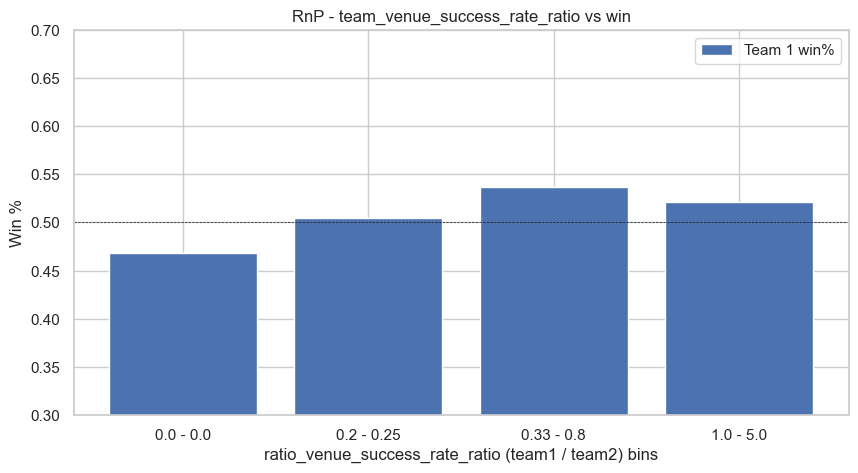

Correlation between team_venue_success_rate_ratio and winner_01 is: -0.046377382165254694


In [44]:
createRnP(train_data, 'team_venue_success_rate_ratio')

6.

In [45]:
def seasonal_venue_performance(match_lvl_data, team_id, venue_name, season, date, recent_n=5):
    matches_at_venue_season = match_lvl_data[((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id)) &
                                             (match_lvl_data['venue'] == venue_name) &
                                             (match_lvl_data['season'] == season) &
                                             (match_lvl_data['match_dt'] < date)].tail(recent_n)
    wins = matches_at_venue_season['winner_id'].apply(lambda x: 1 if x == team_id else 0).sum()
    return (wins / recent_n) if matches_at_venue_season.shape[0] > 0 else 0

In [46]:
train_data['team1_seasonal_venue_win_rate'] = train_data.apply(lambda x: seasonal_venue_performance(match_lvl_data, x['team1_id'], x['venue'], x['season'], x['match_dt'], recent_n=num_matches), axis=1)
train_data['team2_seasonal_venue_win_rate'] = train_data.apply(lambda x: seasonal_venue_performance(match_lvl_data, x['team2_id'], x['venue'], x['season'], x['match_dt'], recent_n=num_matches), axis=1)

train_data = add_ratio_column(train_data, 'team1_seasonal_venue_win_rate', 'team2_seasonal_venue_win_rate', 'team_seasonal_venue_win_rate_ratio')

train_data.drop(['team1_seasonal_venue_win_rate', 'team2_seasonal_venue_win_rate'], axis=1, inplace=True)

test_data['team1_seasonal_venue_win_rate'] = test_data.apply(lambda x: seasonal_venue_performance(match_lvl_data, x['team1_id'], x['venue'], x['season'], x['match_dt'], recent_n=num_matches), axis=1)
test_data['team2_seasonal_venue_win_rate'] = test_data.apply(lambda x: seasonal_venue_performance(match_lvl_data, x['team2_id'], x['venue'], x['season'], x['match_dt'], recent_n=num_matches), axis=1)

test_data = add_ratio_column(test_data, 'team1_seasonal_venue_win_rate', 'team2_seasonal_venue_win_rate', 'team_seasonal_venue_win_rate_ratio')

test_data.drop(['team1_seasonal_venue_win_rate', 'team2_seasonal_venue_win_rate'], axis=1, inplace=True)

slope: 0.57 / 0.48 =  1.18


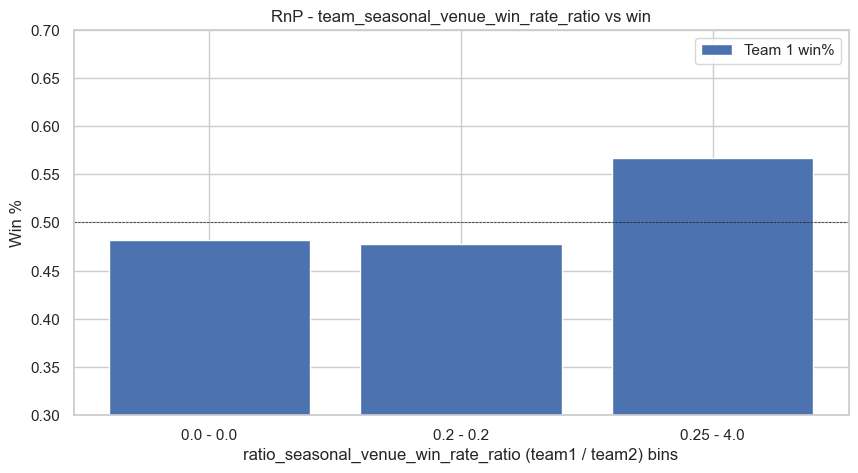

Correlation between team_seasonal_venue_win_rate_ratio and winner_01 is: -0.084639544446992


In [47]:
createRnP(train_data, 'team_seasonal_venue_win_rate_ratio')

7

In [48]:
def city_success_rate(match_lvl_data, team_id, city_name, date, recent_n=5):
    matches_in_city = match_lvl_data[((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id)) &
                                     (match_lvl_data['city'] == city_name) &
                                     (match_lvl_data['match_dt'] < date)].tail(recent_n)
    wins = matches_in_city['winner_id'].apply(lambda x: 1 if x == team_id else 0).sum()
    return (wins / recent_n) if matches_in_city.shape[0] > 0 else 0

In [49]:
train_data['team1_city_success_rate'] = train_data.apply(lambda x: city_success_rate(match_lvl_data, x['team1_id'], x['city'], x['match_dt'], recent_n=num_matches), axis=1)
train_data['team2_city_success_rate'] = train_data.apply(lambda x: city_success_rate(match_lvl_data, x['team2_id'], x['city'], x['match_dt'], recent_n=num_matches), axis=1)

train_data = add_ratio_column(train_data, 'team1_city_success_rate', 'team2_city_success_rate', 'team_city_success_rate_ratio')

train_data.drop(['team1_city_success_rate', 'team2_city_success_rate'], axis=1, inplace=True)

test_data['team1_city_success_rate'] = test_data.apply(lambda x: city_success_rate(match_lvl_data, x['team1_id'], x['city'], x['match_dt'], recent_n=num_matches), axis=1)
test_data['team2_city_success_rate'] = test_data.apply(lambda x: city_success_rate(match_lvl_data, x['team2_id'], x['city'], x['match_dt'], recent_n=num_matches), axis=1)

test_data = add_ratio_column(test_data, 'team1_city_success_rate', 'team2_city_success_rate', 'team_city_success_rate_ratio')

test_data.drop(['team1_city_success_rate', 'team2_city_success_rate'], axis=1, inplace=True)

slope: 0.53 / 0.48 =  1.1


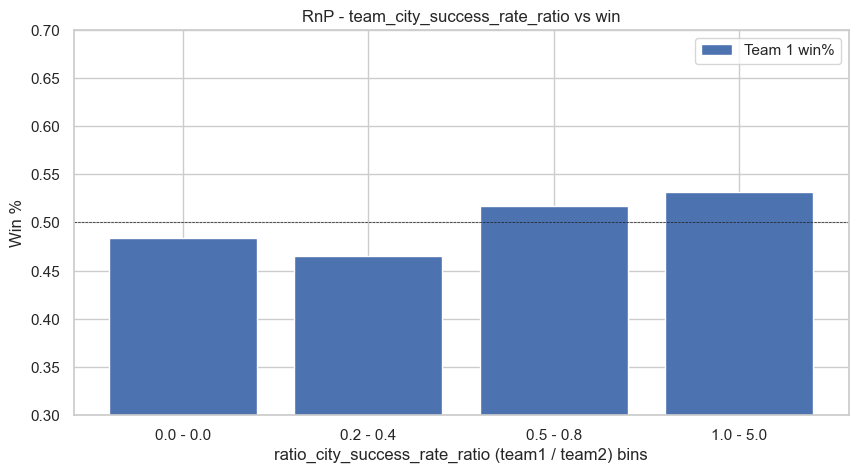

Correlation between team_city_success_rate_ratio and winner_01 is: -0.03854835767156852


In [50]:
createRnP(train_data, 'team_city_success_rate_ratio')